In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import pickle as pkl
# import notebook_helper
import sys
import numpy as np
import imodelsx
import imodelsx.process_results
import sasc.data.data
from sasc.data.data import TASKS_D3
import warnings
import scipy.stats
def sem(x):
    '''Compute standard error of the mean, ignoring NaNs
    '''
    with warnings.catch_warnings():
        return scipy.stats.sem(x, ddof=0)
tqdm.pandas()
TASK_NAMES = list(TASKS_D3.keys())
sys.path.append('../experiments/')
# results_dir = '/home/chansingh/mntv1/mprompt/feb18_synthetic_sweep'
results_dir = '/home/chansingh/mntv1/mprompt/feb25'

In [ ]:
r = pd.read_pickle('../results/results_synthetic.pkl')

In [ ]:
# simplifying
default_params = {
    'noise_ngram_scores': 0,
    'module_num_restrict': -1,
}
rd = r
for k, v in default_params.items():
    rd = rd[rd[k] == v]

# Top results

In [ ]:
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 200):
    d = (
        rd[[
            'task_keyword', 'top_explanation_init_strs',
            'top_contains_keywords',  # 'mean_contains_keywords',
            'top_score_synthetic', 'module_num', 'seed'
        ]]
        .rename(columns={
            'task_keyword': 'GT Explanation',
            'top_explanation_init_strs': 'Generated Explanation',
        })
    )
    d_ = d[d.top_contains_keywords == 0]
    slice_ = pd.IndexSlice[d_.index, d_.columns]

    # s = d.style
    display(
        d
        .style.hide()
        .set_properties(**{'background-color': '#132639'}, subset=slice_)
        .format(precision=2)
    )

# Details

**Selected examples**

In [ ]:
pos_examples = [(25, 2), (4, 1), (21, 1), (42, 1), (7, 1),
                (50, 1), (41, 1), (8, 1), (45, 1), (47, 1)]
neg_examples = [(18, 1), (26, 1), (39, 1), (2, 1)]

with pd.option_context('display.max_colwidth', None, 'display.max_rows', 200):
    tab = (
        pd.concat([rd[(rd.module_num == x[0]) & (rd.seed == x[1])]
                  for x in pos_examples + neg_examples])
        [[
            'task_keyword', 'top_explanation_init_strs',
        ]]
        .rename(columns={
                'task_keyword': 'Groundtruth Explanation',
                'top_explanation_init_strs': 'Generated Explanation',
                })
    )
    display(tab)
dummy = [''] * tab.shape[0]
dummy[0] = '\\parbox[c]{1mm}{\\multirow{' + \
    str(len(pos_examples)) + '}{*}{\\rotatebox[origin=c]{90} {Correct}}}'
dummy[len(pos_examples)] = '\\parbox[c]{1mm}{\\multirow{' + str(
    len(neg_examples)) + '}{*}{\\rotatebox[origin=c]{90} {Incorrect}}}'
tab.insert(0, ' ', dummy)
print(tab.style.hide(axis="index").to_latex(hrules=True).replace(
    'science \\\\', 'science \\\\ \n\midrule'))

**More details**

In [ ]:
# display full strings
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 200):
    display(
        rd
        .filter(['task_keyword', 'top_explanation_init_strs', 'top_contains_keywords', 'top_score_synthetic', 'module_num'])
        # .filter(['top_score_contains_keywords', 'top_score_synthetic', 'top_explanation_init_strs', 'explanation_init_ngrams', 'module_num'])
        # .filter(['top_explanation_init_strs', 'explanation_init_ngrams', 'top_strs_added'])
        # .filter(['explanation_init_strs', 'explanation_init_ngrams',])
        # .head(n=20)
    )

# Extra evaluation

### Export regexes

In [ ]:
from sasc.data.d3 import TASKS_D3

In [ ]:
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 200):
    cols = {'index': 'Module name',
            'groundtruth_explanation': 'Dataset explanation', 'check_func': 'Regex check'}
    d = pd.DataFrame(TASKS_D3).T.reset_index()[
        cols.keys()].rename(columns=cols)
    d['Module name'] = d['Module name'].apply(
        lambda x: x.replace('d3_', '').replace('_', '-'))
    print(d.to_latex(index=False).replace('|', '$|$'))

### Analyze simiilaries with GT explanations

In [ ]:
rd1 = rd[rd.seed == 1]
rd1 = rd1[['top_explanation_init_strs', 'task_keyword',
           'task_name (groundtruth)', 'module_num']].sort_values(by='module_num')
rd1

In [ ]:
# generate similarity matrix of explanations and groundtruth texts using bge-large
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-reranker-large')
model = AutoModelForSequenceClassification.from_pretrained(
    'BAAI/bge-reranker-large')
model.eval()

texts_gen = rd1['top_explanation_init_strs'].values.tolist()
texts_gt = rd1['task_keyword'].values.tolist()
n = len(texts_gen)
pairs = []
for r in range(n):
    for c in range(n):
        pairs.append([texts_gen[r], texts_gt[c]])

# pairs = [pairs1[:3], pairs2[:3]]
# pairs = [['sarcasm', 'sarcasm'],
        #  ['sarcasm', 'unbiased']]
# pairs = [['what is panda?', 'hi'], ['what is panda?',
# 'The giant panda (Ailuropoda melanoleuca), sometimes called a panda bear or simply panda, is a bear species endemic to China.']]


with torch.no_grad():
    inputs = tokenizer(pairs, padding=True, truncation=True,
                       return_tensors='pt', max_length=512)
    scores = model(**inputs, return_dict=True).logits.view(-1, ).float()
out = scores.reshape((n, n))

In [ ]:
plt.imshow(out)
cb = plt.colorbar()
cb.set_label(label='Similarity score (Higher is more similar)', size='small')
plt.ylabel('Generated explanation per dataset')
plt.xlabel('Groundtruth explanation per dataset')
plt.tight_layout()
plt.savefig('synthetic_scores_sim_matrix.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# calculate top-k acc, accounting for ties
for k in [1, 2]:
    correct_count = 0
    for c in range(n):
        unique_vals = np.unique(out[:, c])[::-1]
        val_diag = out[c, c]
        if val_diag >= unique_vals[k - 1]:
            correct_count += 1
    print('top' + str(k) + '-acc', correct_count / n)

# Evaluating all texts rather than negative texts

In [ ]:
rd1 = rd[rd.seed == 1]
rd1 = rd1.sort_values(by='module_num')
n = len(rd1)

In [ ]:
from sasc.modules.emb_diff_module import EmbDiffModule
from sasc.data.d3 import TASKS_D3
from collections import defaultdict

d = defaultdict(list)

# initialize model
m = EmbDiffModule(
    task_str='d3_0_irony',
)

for i in tqdm(range(n)):

    # load module
    row = rd1.iloc[i]
    task_str = list(TASKS_D3.keys())[row['module_num']]
    m._init_task(task_str)

    assert abs(
        (np.mean(m(row['top_strs_added'])) -
         np.mean(m(row['top_strs_removed']))
         )
        - row['top_score_synthetic']) < 1e-1

    for j in range(n):
        row_eval = rd1.iloc[j]

        d['i'].append(i)
        d['j'].append(j)
        d['score_added'].append(m(row_eval['top_strs_added']))
        d['score_removed'].append(m(row_eval['top_strs_removed']))

In [133]:
df = pd.DataFrame(d)
df['added'] = df['score_added'].apply(lambda x: np.mean(x))
df['removed'] = df['score_removed'].apply(lambda x: np.mean(x))
df

,i,j,score_added,score_removed,added,removed
0,0,0,"[-0.8811241507071529, -0.916004910130155, -0.8...","[-0.982652681765082, -0.9997531693526941, -1.0...",-0.834726,-1.007341
1,0,1,"[-0.9630515176418337, -0.9451296524030018, -0....","[-1.0183531112006246, -0.9859219019264988, -0....",-0.958424,-0.959225
2,0,2,"[-0.9843971009246647, -1.0575905282493918, -0....","[-1.0528231069604783, -1.0420089717950722, -0....",-1.005829,-1.043729
3,0,3,"[-1.0398598236814456, -1.00354692795573, -1.04...","[-1.066462149227688, -1.003821070523948, -1.06...",-1.037695,-1.052938
4,0,4,"[-0.9995324531867431, -0.975631186835391, -0.9...","[-1.0928068691044965, -1.0675976561762064, -0....",-0.997451,-1.045948
...,...,...,...,...,...,...
2911,53,49,"[-1.1208926528057186, -1.1023942393748818, -1....","[-1.1217431925677406, -1.1010811437605679, -1....",-1.081838,-1.090783
2912,53,50,"[-1.051554698576432, -1.0740868425822105, -1.0...","[-1.0966302323618708, -1.1153290903326747, -1....",-1.075268,-1.090063
2913,53,51,"[-1.0896496873925383, -1.1035806158026826, -1....","[-1.0458627404619119, -1.0534974663964298, -1....",-1.057495,-0.915106
2914,53,52,"[-1.0787639181765822, -1.054626091907554, -1.0...","[-1.0940296470858009, -1.104074264429083, -1.1...",-1.047607,-1.091940


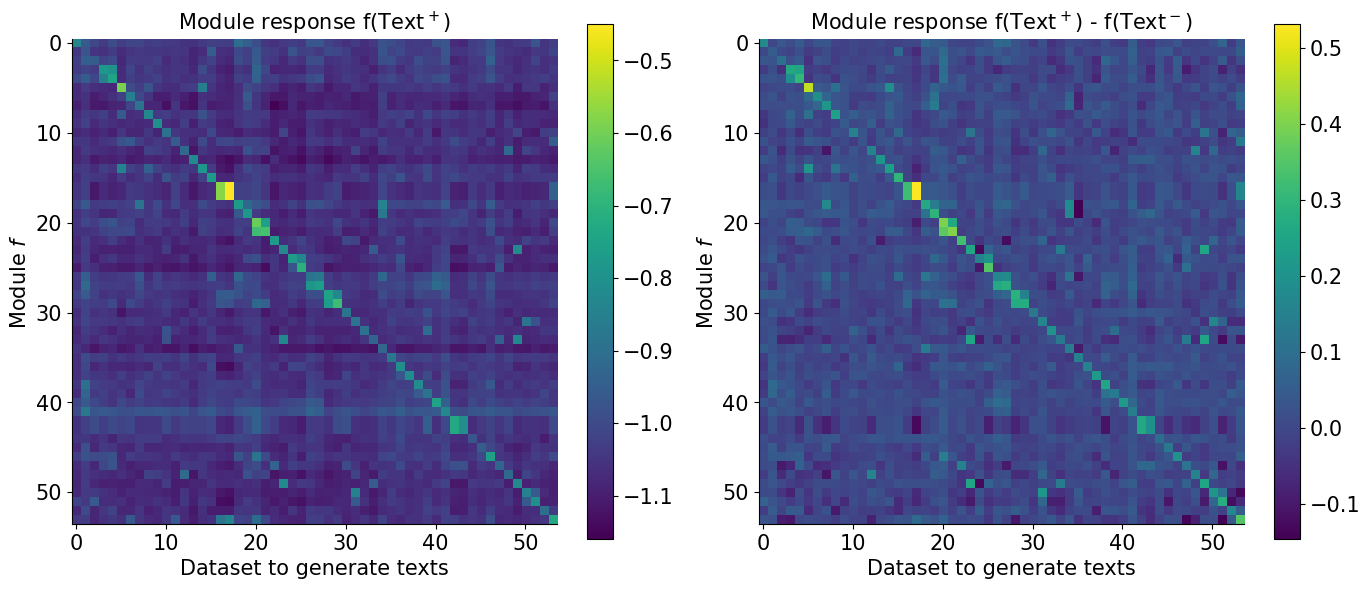

In [178]:
added = df['added'].values.reshape((n, n))
removed = df['removed'].values.reshape((n, n))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(added)
plt.ylabel('Module $f$')
plt.xlabel('Dataset to generate texts')
plt.title('Module response f(Text$^+$)', fontsize='medium')
plt.colorbar()

plt.subplot(1, 2, 2)

plt.imshow(added - removed)
plt.ylabel('Module $f$')
plt.xlabel('Dataset to generate texts')
plt.title('Module response f(Text$^+$) - f(Text$^-$)', fontsize='medium')
plt.colorbar()
plt.savefig('mod_response_synthetic.pdf', bbox_inches='tight')
plt.show()

In [177]:
# subtract diag mean from non-diag mean
print('orig', added[np.eye(n).astype(bool)].mean() -
      added[~np.eye(n).astype(bool)].mean())

diff = added - removed
print('diff', diff[np.eye(n).astype(bool)].mean())

orig 0.23763210418647707
diff 0.22060064169403173
